#### Import des librairies

In [1]:
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
import imageio
from IPython import display

#### Les fonctions

In [2]:
def make_grid(dim=100, p=0.4):    
    """Une simple fonction qui renvoie une matrice de taille dim x dim, 
    remplie de 1 pour les arbres et de 0 pour les espaces vides, 
    avec un probabilité p d'avoir des arbres"""    
    grid = np.random.choice([1.,0.],dim*dim,p=[p,1-p]).reshape((dim,dim))
    return grid
    
def start_fire(grid, n):
    """Fonction qui initie le feu à n endroits au hasard dans la forêt et renvoie 
    les coordonnées de ces foyers"""    
    c = np.argwhere(grid>0)
    if len(c) == 0:
        return []
    else:
        index = np.random.choice(c.shape[0], n, replace=False)
        idx = c[index]    
        for i in idx:  
            grid[tuple(i)] = 0.5
        return idx

def unpad(grid):
    """Fonction qui permet d'enlever le pad d'épaisseur 1 rajouté à la matrice grid dans la fonction 
    propage()"""
    grid = grid[1:-1,1:-1]
    return grid

def propage(grid, f):
    """fonction qui simule la propagation du feu d'un tour à l'autre"""    
    #On pad de 1 pour ne pas s'enconbrer de conditions trop lourdes coucernant les points en dehors de la map
    pgrid = np.pad(grid, 1, 'constant', constant_values=0)
    feu = []
    for coord in f: 
        # Feu tour n-1 devient terre
        pgrid[tuple([coord[0]+1,coord[1]+1])] = 0 
        # Arbres proche du feu prennent feu
        if pgrid[coord[0]+1,coord[1]] == 1: 
            pgrid[coord[0]+1,coord[1]] = 0.5
            feu.append([coord[0],coord[1]-1])
        if pgrid[coord[0]+1,coord[1]+2] == 1: 
            pgrid[coord[0]+1,coord[1]+2] = 0.5
            feu.append([coord[0],coord[1]+1])
        if pgrid[coord[0],coord[1]+1] == 1: 
            pgrid[coord[0],coord[1]+1] = 0.5
            feu.append([coord[0]-1,coord[1]])
        if pgrid[coord[0]+2,coord[1]+1] == 1: 
            pgrid[coord[0]+2,coord[1]+1] = 0.5
            feu.append([coord[0]+1,coord[1]])                 
    pgrid = unpad(pgrid)                    
    return pgrid, feu

def remove_files(path='images/'):
    """Fonction permettant de supprimer tous les fichiers d'un répertoire, ici nous supprimons les images
    du répertoire du même nom"""
    files = glob.glob(path+'*')
    for f in files:
        os.remove(f)

def avg_ratio(nb_iter, dim, p, f):
    """Une fonction permettant de calculer le taux moyen d'arbres restants en fonction du taux initial p et 
    la moyenne est calculée à partir des nb_iter"""
    avg_ratio = 0
    for i in range(nb_iter):
        avg_ratio += tree_ratio(dim, p, f)
    return avg_ratio/nb_iter if nb_iter>0 else 0

def tree_ratio(dim, p, f):
    """Permet de calculer le ration arbres restants sur arbres à l'état initial"""
    grid = make_grid(dim, p)
    feu = start_fire(grid, f)
    while len(feu) > 0:
        grid, feu = propage(grid, feu)
    return (np.count_nonzero(grid == 1)/(dim*dim))/p if (dim>0 and p>0) else 1

#### L'animation

In [3]:
t_foret = 100
grid = make_grid(t_foret, 0.6)
feu = start_fire(grid, 2)
cmap = colors.ListedColormap(['gray','red', 'green']) 

remove_files()

i = 0
while len(feu) > 0:    
    fig = plt.figure(figsize=(12,12))
    plt.matshow(grid, cmap=cmap, fignum=1)
    plt.axis('off')
    plt.title('Forêt prenant feu')
    plt.savefig('images/percolation{:04d}.png'.format(i))
    plt.close('all')
    grid, feu = propage(grid, feu)
    i += 1

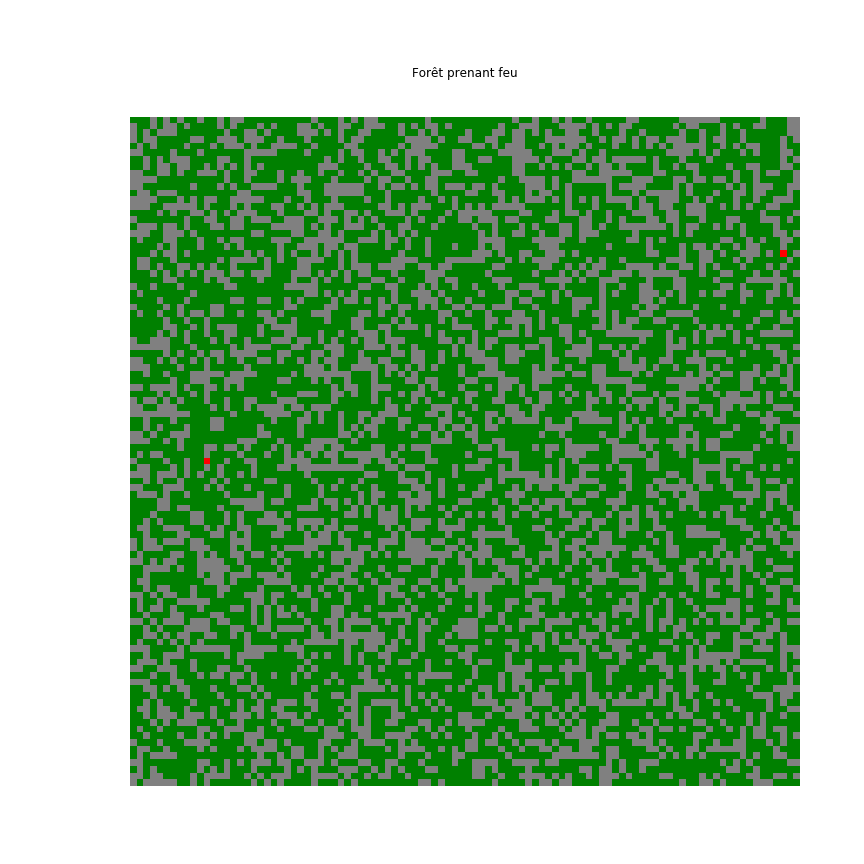

In [4]:
# On génère un GIF à partir des images enrégistrées
anim_file = 'percolation.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob.glob('images/percolation*.png')
    filenames = sorted(filenames)
    last = -1
    for i,filename in enumerate(filenames):
        frame = 2*(i**0.6)   # Ici on gère la vitesse du GIF
        if round(frame) > round(last):
            last = frame
        else:
            continue
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)

display.Image(filename=anim_file)

#### Analyse du seuil de percolation

In [5]:
ratio1, ratio2, ratio3 = [], [], []
for p in np.linspace(0.01,1,num=100):
    ratio1.append(avg_ratio(nb_iter=500, dim=100, p=p, f=1))
    ratio2.append(avg_ratio(nb_iter=500, dim=100, p=p, f=2))
    ratio3.append(avg_ratio(nb_iter=500, dim=100, p=p, f=3))

KeyboardInterrupt: 

In [ ]:
ratio4, ratio5, ratio6 = [], [], []
for p in np.linspace(0,1,num=101):
    ratio4.append(avg_ratio(nb_iter=500, dim=50, p=p, f=1))
    ratio5.append(avg_ratio(nb_iter=500, dim=100, p=p, f=1))
    ratio6.append(avg_ratio(nb_iter=500, dim=200, p=p, f=1))

In [ ]:
fig = plt.figure(figsize=(15,10))
plt.plot(range(1,101), ratio1, color='r', label='Un foyer')
plt.plot(range(1,101), ratio2, color='b', label='Deux foyers')
plt.plot(range(1,101), ratio3, color='g', label='Trois foyers')
plt.xlabel('Densité initiale (%)')
plt.ylabel('Arbres restants')
plt.title('Seuil de percolation pour un nombre de foyers allant de 1 à 3')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
fig = plt.figure(figsize=(15,10))
plt.plot(range(1,101), ratio4, color='r', label='50*50')
plt.plot(range(1,101), ratio5, color='b', label='100*100')
plt.plot(range(1,101), ratio6, color='g', label='200*200')
plt.xlabel('Densité initiale (%)')
plt.ylabel('Arbres restants')
plt.title('Seuil de percolation pour différentes tailles de forêt')
plt.legend(title='Superficie (u.a.)')
plt.grid(True)
plt.show()